# Patches with Simulation Data

#### Description

The aim here is to apply Patches to the simulated data (here: t100,s80,b0) in its interpretability mode to get interpretable scores. These scores will then be compared to the gene ground truths (i.e., is a gene a type or state gene, or both) and to the typeness and stateness scores from the FSS paper.

Given gene expression profiles and condition labels, Patches produces two latent representations of each cell, a common representation (similar across all conditions) and a condition-specific representation (similar inside of each condition). From these representations, a linear decoder can reconstruct gene expression profiles while providing interpretable attribute scores and a common score for each gene via  its weights. Importantly, one common score is returned as the sum of the weights corresponding to the dimensions of the common latent representation, and one attribute score is returned for each attribute of all conditions as the sum of the weights corresponding to the dimensions of each attribute in the condition-specific latent representation.

Due to that, a cell type score can only be obtained if the cell types are input as condition to the model, i.e., they must be know (or obtained by clustering + marker gene analysis). A single cell type or state score could potentially be obtained by combining the attribute scores of all type or state attributes (e.g., sum of absolutes or sum of squares), respectively. The common score might contain cell type information if the cell type is not given as condition to the model, but this is to be explored.

Thus, Patches is run with both only state as condition and type + state as conditions, and the scores are further explored as described above. The workflow is adapted from this tutorial: https://ladder.readthedocs.io/en/latest/notebooks/interpretable_vu_tutorial.html


#### Possible Improvements:

- data preparation:
    - run with all genes or run with HVGs (get scores for all genes vs. better performance with top 1500 genes)
    - ~~batch effect correction~~ *does not seem to have a noticable influence here*

- `workflow.prep_model`:
    - ~~run with or without `batch_key` (here: `batch_key = sample_id`)~~ *does not make noticable difference and makes sense to do batch correction*
    - ~~use `cell_type_label_key = cluster_id` (clusters correspond to cell type in simulation)~~ *only used for subsetting evaluation for a cell type*
    - use different `minibatch_size` (default is 128, maybe try smaller size with ~2000 cells)
    - ~~tune `model_args` and `optim_args`~~ *maybe consider lr otherwise not necessary*

- `workflow.run_model`:
    - run with different number of `max_epochs` (default is 1500)
    - try different `convergence_threshold` and `convergence_window`

## Import Packages

In [1]:
import scanpy as sc
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from ladder.scripts import InterpretableWorkflow
from umap import UMAP

## Helper Functions

In [2]:
def force_aspect(ax, aspect=1):
    """
    Force aspect ratio of a matplotlib axis to be equal. Helper function for plotting.
    Taken from Patches tutorial docs.

    Parameters
    ----------
    ax : matplotlib axis
        The axis to set the aspect ratio for.
    aspect : float, optional
        The aspect ratio to set. Default is 1 (equal).
    """
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

def create_umap_df(workflow, model):
    """
    Create a dataframe with UMAP and PCA reductions for plotting.
    Adapted from Patches tutorial docs.

    Parameters
    ----------
    workflow : InterpretableWorkflow
        The fitted InterpretableWorkflow object.
    model : str
        The model type, either "Patches" or "Base".
    
    Returns
    -------
    pd.DataFrame
        A dataframe with UMAP and PCA reductions for plotting.
    """
    # UMAP reducers
    reducer_base = UMAP(n_neighbors=50, min_dist=0.1, metric="correlation", verbose=False, random_state=42)
    reducer = UMAP(n_neighbors=50, min_dist=0.1, metric="correlation", verbose=False, random_state=42)

    match model:
        case "Patches":
            # all data reductions needed for the plots
            base_umap = reducer_base.fit_transform(np.array(workflow.anndata.X))
            z_umap = reducer.fit_transform(workflow.anndata.obsm['patches_z_latent']) # Z
            w_umap = reducer.fit_transform(workflow.anndata.obsm['patches_w_latent']) # W
            
            w_pca = sc.pp.pca(workflow.anndata.obsm['patches_w_latent'], random_state=42)[:,:2] # W PCA, grab first 2 PCs
            z_pca = sc.pp.pca(workflow.anndata.obsm['patches_z_latent'], random_state=42)[:,:2] # Z PCA, grab first 2 PCs

            # create dataframe and add all reductions
            df = pd.DataFrame(base_umap)
            df.index = workflow.anndata.obs.index
            
            df.columns = ["base_1", "base_2"]
            df["z_umap_1"], df["z_umap_2"] = z_umap[:,0], z_umap[:,1]
            df["w_umap_1"], df["w_umap_2"] = w_umap[:,0], w_umap[:,1]
            df["z_pc_1"], df["z_pc_2"] = z_pca[:,0], z_pca[:,1]
            df["w_pc_1"], df["w_pc_2"] = w_pca[:,0], w_pca[:,1]

        case "Base":
            anndata = workflow.anndata.copy()
            anndata.X = anndata.layers["counts"]
            
            sc.pp.normalize_total(anndata, target_sum=1e4)
            sc.pp.log1p(anndata)
            sc.tl.pca(anndata, svd_solver="arpack")
            
            base_umap = reducer_base.fit_transform(np.array(anndata.X))
            base_pca = anndata.obsm['X_pca'][:,:2]

            df = pd.DataFrame(base_umap)
            df.index = anndata.obs.index

            df.columns = ["base_umap_1", "base_umap_2"]
            df["base_pc_1"], df["base_pc_2"] = base_pca[:,0], base_pca[:,1]

    # add metadata
    df["group_id"], df["cluster_id"], df["sample_id"] = workflow.anndata.obs["group_id"], workflow.anndata.obs["cluster_id"], workflow.anndata.obs["sample_id"]

    return df

## Load and Prepare Data

The reconstruction performance seems to be influenced a lot by the genes used: a significant increase in performance is observed when using the 1500 highest variable genes instead of all 1979 genes. A further increase in performance with harsher filtering (e.g., top 100 highly variable genes) is not visible. While achiving a lower performance, using all genes gives a larger group to compare to the FSS scores (here, all genes are used). Due to that, workflows for both HVGs and all genes are run.

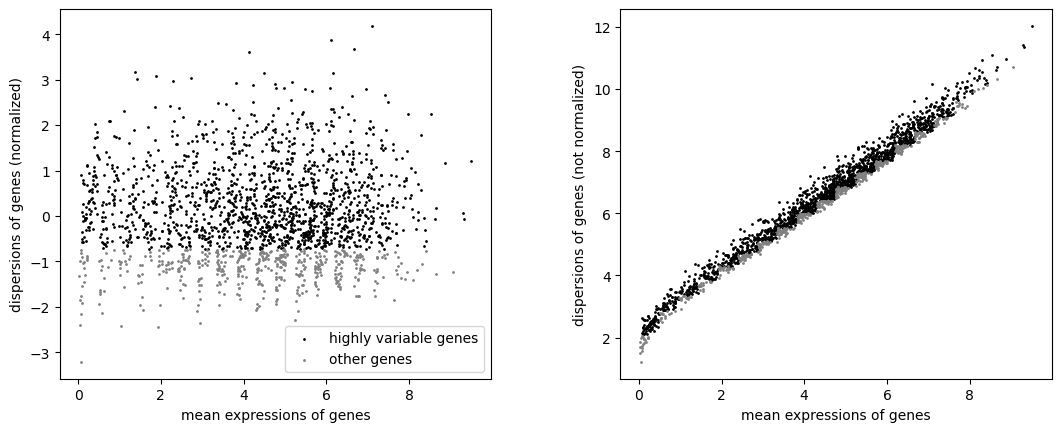

Full data shape: (2412, 1979), HVG data shape: (2412, 1500)


In [3]:
# load data
adata = sc.read_h5ad("../../data/sim/01-pro/t100,s80,b0.h5ad")

# full adata
adata_full = adata.copy()

# highly variable gene selection on log-normalized data
adata.X = adata.layers["logcounts"]
sc.pp.highly_variable_genes(adata, n_top_genes=1500)
sc.pl.highly_variable_genes(adata)
adata_hvg = adata[:, adata.var["highly_variable"]].copy()

# reset to raw counts for model input (as stated in docs)
adata_full.X = adata_full.layers["counts"]
adata_hvg.X = adata_hvg.layers["counts"]

print(f"Full data shape: {adata_full.shape}, HVG data shape: {adata_hvg.shape}")

## Run Patches in Interpretable Workflow

### Hyperparameters

The main difference in performance (especially for the scores in downstream analyses) seems to be controlled by the number of epochs. Even though the loss does not decrease much after around 500 epochs, downstream performance of Patches scores is significantly improved when training with 1500 epochs compared to training with 500 epochs. Learning rate and batch size do not seem to make a sigificant difference in performance.

In [4]:
# hyperparameters for full data
lr_full = 0.0098
epochs_full = 1500
minibatch_size_full = 32

# hyperparameters for hvg data
lr_hvg = 0.0065
epochs_hvg = 2500
minibatch_size_hvg = 32

# hyperparameters for both
convergence_threshold = 1e-4
convergence_window = 50
random_seed = 42
batch_key = "sample_id"

### Full Data + Condtion (State) Only - Workflow1

In [5]:
# initialize workflow object
workflow1 = InterpretableWorkflow(
    adata_full.copy(),
    verbose=True,
    random_seed=random_seed
)

# define the condition classes & batch key to prepare the data
factors = ["group_id"]
workflow1.prep_model(
    factors,
    batch_key=batch_key,
    minibatch_size=minibatch_size_full,
    model_type="Patches",
    model_args={"ld_normalize" : True},
    optim_args={"lr" : lr_full})

# run model
workflow1.run_model(max_epochs=epochs_full, convergence_threshold=convergence_threshold, convergence_window=convergence_window)
workflow1.save_model("../../data/sim/02-scores_patches/t100,s80,b0-patches_con_full")

Initialized workflow to run interpretable model.

Condition classes : ['group_id']
Number of attributes per class : [2]

Initialized Patches model.
Model arguments: {'ld_normalize': True, 'reconstruction': 'ZINB_LD', 'batch_correction': True, 'scale_factor': 1.579080343607883e-05, 'num_labels': 2, 'len_attrs': [2]}

Optimizer args parsed successfully. Final arguments: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optim_args': {'lr': 0.0098, 'eps': 0.01, 'betas': (0.9, 0.999)}, 'gamma': 1, 'milestones': [10000000000.0]}
Training initialized for a maximum of 1500, with convergence eps 0.0001.
Using device: cpu

Epoch : 0 || Train Loss: 57.60716 // 0.60613 || Test Loss: 12.2943 // 0.48014 || Warmup : False
Epoch : 1 || Train Loss: 9.67661 // 0.78318 || Test Loss: 7.41436 // 0.87229 || Warmup : False
Epoch : 2 || Train Loss: 7.1649 // 0.69754 || Test Loss: 6.51022 // 0.70913 || Warmup : False
Epoch : 3 || Train Loss: 6.23236 // 0.7036 || Test Loss: 6.08564 // 0.69387 || Warmup : False
Ep

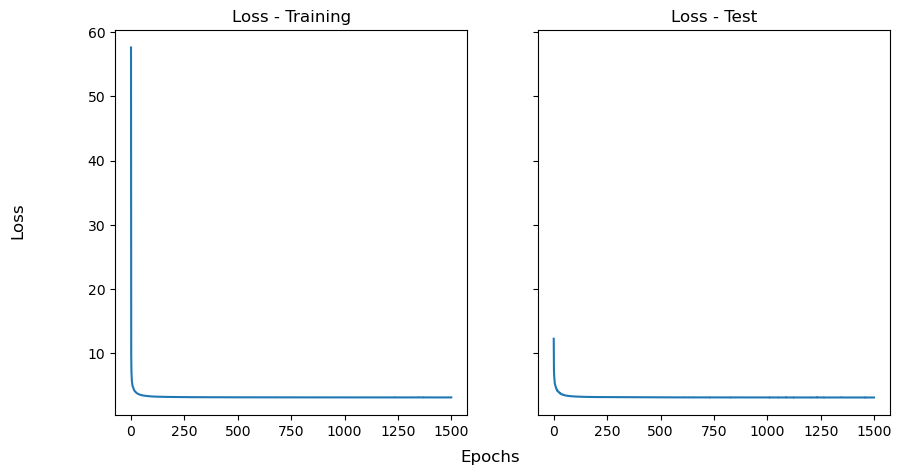

In [6]:
# inspect loss
workflow1.plot_loss()

In [7]:
# save embeddings to adata object
workflow1.write_embeddings()
workflow1.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: PCA, patches_w_latent, patches_z_latent

In [8]:
# evaluate run
workflow1.evaluate_reconstruction()

Calculating RMSE ...


100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


Calculating Profile Correlation ...


100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Calculating 2-Sliced Wasserstein ...


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Calculating Chamfer Discrepancy ...


100%|██████████| 5/5 [00:00<00:00, 185.66it/s]

Results
RMSE : 1.068 +- 0.039
Profile Correlation : 0.989 +- 0.001
2-Sliced Wasserstein : 19.466 +- 1.174
Chamfer Discrepancy : 18812.857 +- 96.75


{'RMSE': [np.float64(1.068), np.float64(0.039)],
 'Profile Correlation': [np.float64(0.989), np.float64(0.001)],
 '2-Sliced Wasserstein': [np.float64(19.466), np.float64(1.174)],
 'Chamfer Discrepancy': [np.float64(18812.857), np.float64(96.75)]}

In [9]:
# get loadings (gene scores)
workflow1.get_conditional_loadings()
workflow1.get_common_loadings()
workflow1.anndata.var

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


sample_1.Group1.Gene._  sample_1.Group1.GeneMean._  \
gene0001              gene_0001                    0.348913   
gene0002              gene_0002                    0.233752   
gene0003              gene_0003                    1.054020   
gene0004              gene_0004                    1.333374   
gene0005              gene_0005                    0.359099   
...                         ...                         ...   
gene1996              gene_1996                    5.450085   
gene1997              gene_1997                    3.712653   
gene1998              gene_1998                    3.358019   
gene1999              gene_1999                    1.414115   
gene2000              gene_2000                    0.033959   

         sample_2.Group1.Gene._  sample_2.Group1.GeneMean._  \
gene0001              gene_0001                    0.339048   
gene0002              gene_0002                    0.266857   
gene0003              gene_0003                    1.055463   
gene0004              gene_0004                    1.354434   
gene0005              gene_0005                    0.359099   
...                         ...                         ...   
gene1996              gene_1996                    5.842951   
gene1997              gene_1997                    4.112237   
gene1998              gene_1998                    2.716563   
gene1999              gene_1999                    1.194894   
gene2000              gene_2000                    0.036506   

         sample_3.Group1.Gene._  sample_3.Group1.GeneMean._  \
gene0001              gene_0001                    0.355008   
gene0002              gene_0002                    0.090465   
gene0003              gene_0003                    1.050622   
gene0004              gene_0004                    3.302799   
gene0005              gene_0005                    0.336419   
...                         ...                         ...   
gene1996              gene_1996                    2.373400   
gene1997              gene_1997                    4.176653   
gene1998              gene_1998                    3.271921   
gene1999              gene_1999                    1.214520   
gene2000              gene_2000                    0.032752   

         sample_4.Group1.Gene._  sample_4.Group1.GeneMean._  \
gene0001              gene_0001                    0.376501   
gene0002              gene_0002                    0.084239   
gene0003              gene_0003                    1.220659   
gene0004              gene_0004                    3.356972   
gene0005              gene_0005                    0.365225   
...                         ...                         ...   
gene1996              gene_1996                    2.211219   
gene1997              gene_1997                    4.402447   
gene1998              gene_1998                    3.314637   
gene1999              gene_1999                    1.187953   
gene2000              gene_2000                    0.034540   

         sample_5.Group1.Gene._  sample_5.Group1.GeneMean._  ...  \
gene0001              gene_0001                    0.318932  ...   
gene0002              gene_0002                    0.262775  ...   
gene0003              gene_0003                    1.215103  ...   
gene0004              gene_0004                    1.311693  ...   
gene0005              gene_0005                    0.338109  ...   
...                         ...                         ...  ...   
gene1996              gene_1996                    5.734554  ...   
gene1997              gene_1997                    4.342350  ...   
gene1998              gene_1998                    3.261122  ...   
gene1999              gene_1999                    1.102327  ...   
gene2000              gene_2000                    0.031469  ...   

         GroupDE.Group3  ConditionDE.Condition2 ConditionDE.Condition1  \
gene0001       1.000000                1.000000               1.000000   
gene0002       1

In [10]:
# save loadings to file
workflow1.anndata.var.loc[:, ["Condition1_score_Patches", "Condition2_score_Patches", "common_score_Patches"]].to_csv(
    "../../data/sim/02-scores_patches/t100,s80,b0-patches_con_full_loadings.csv"
)

/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


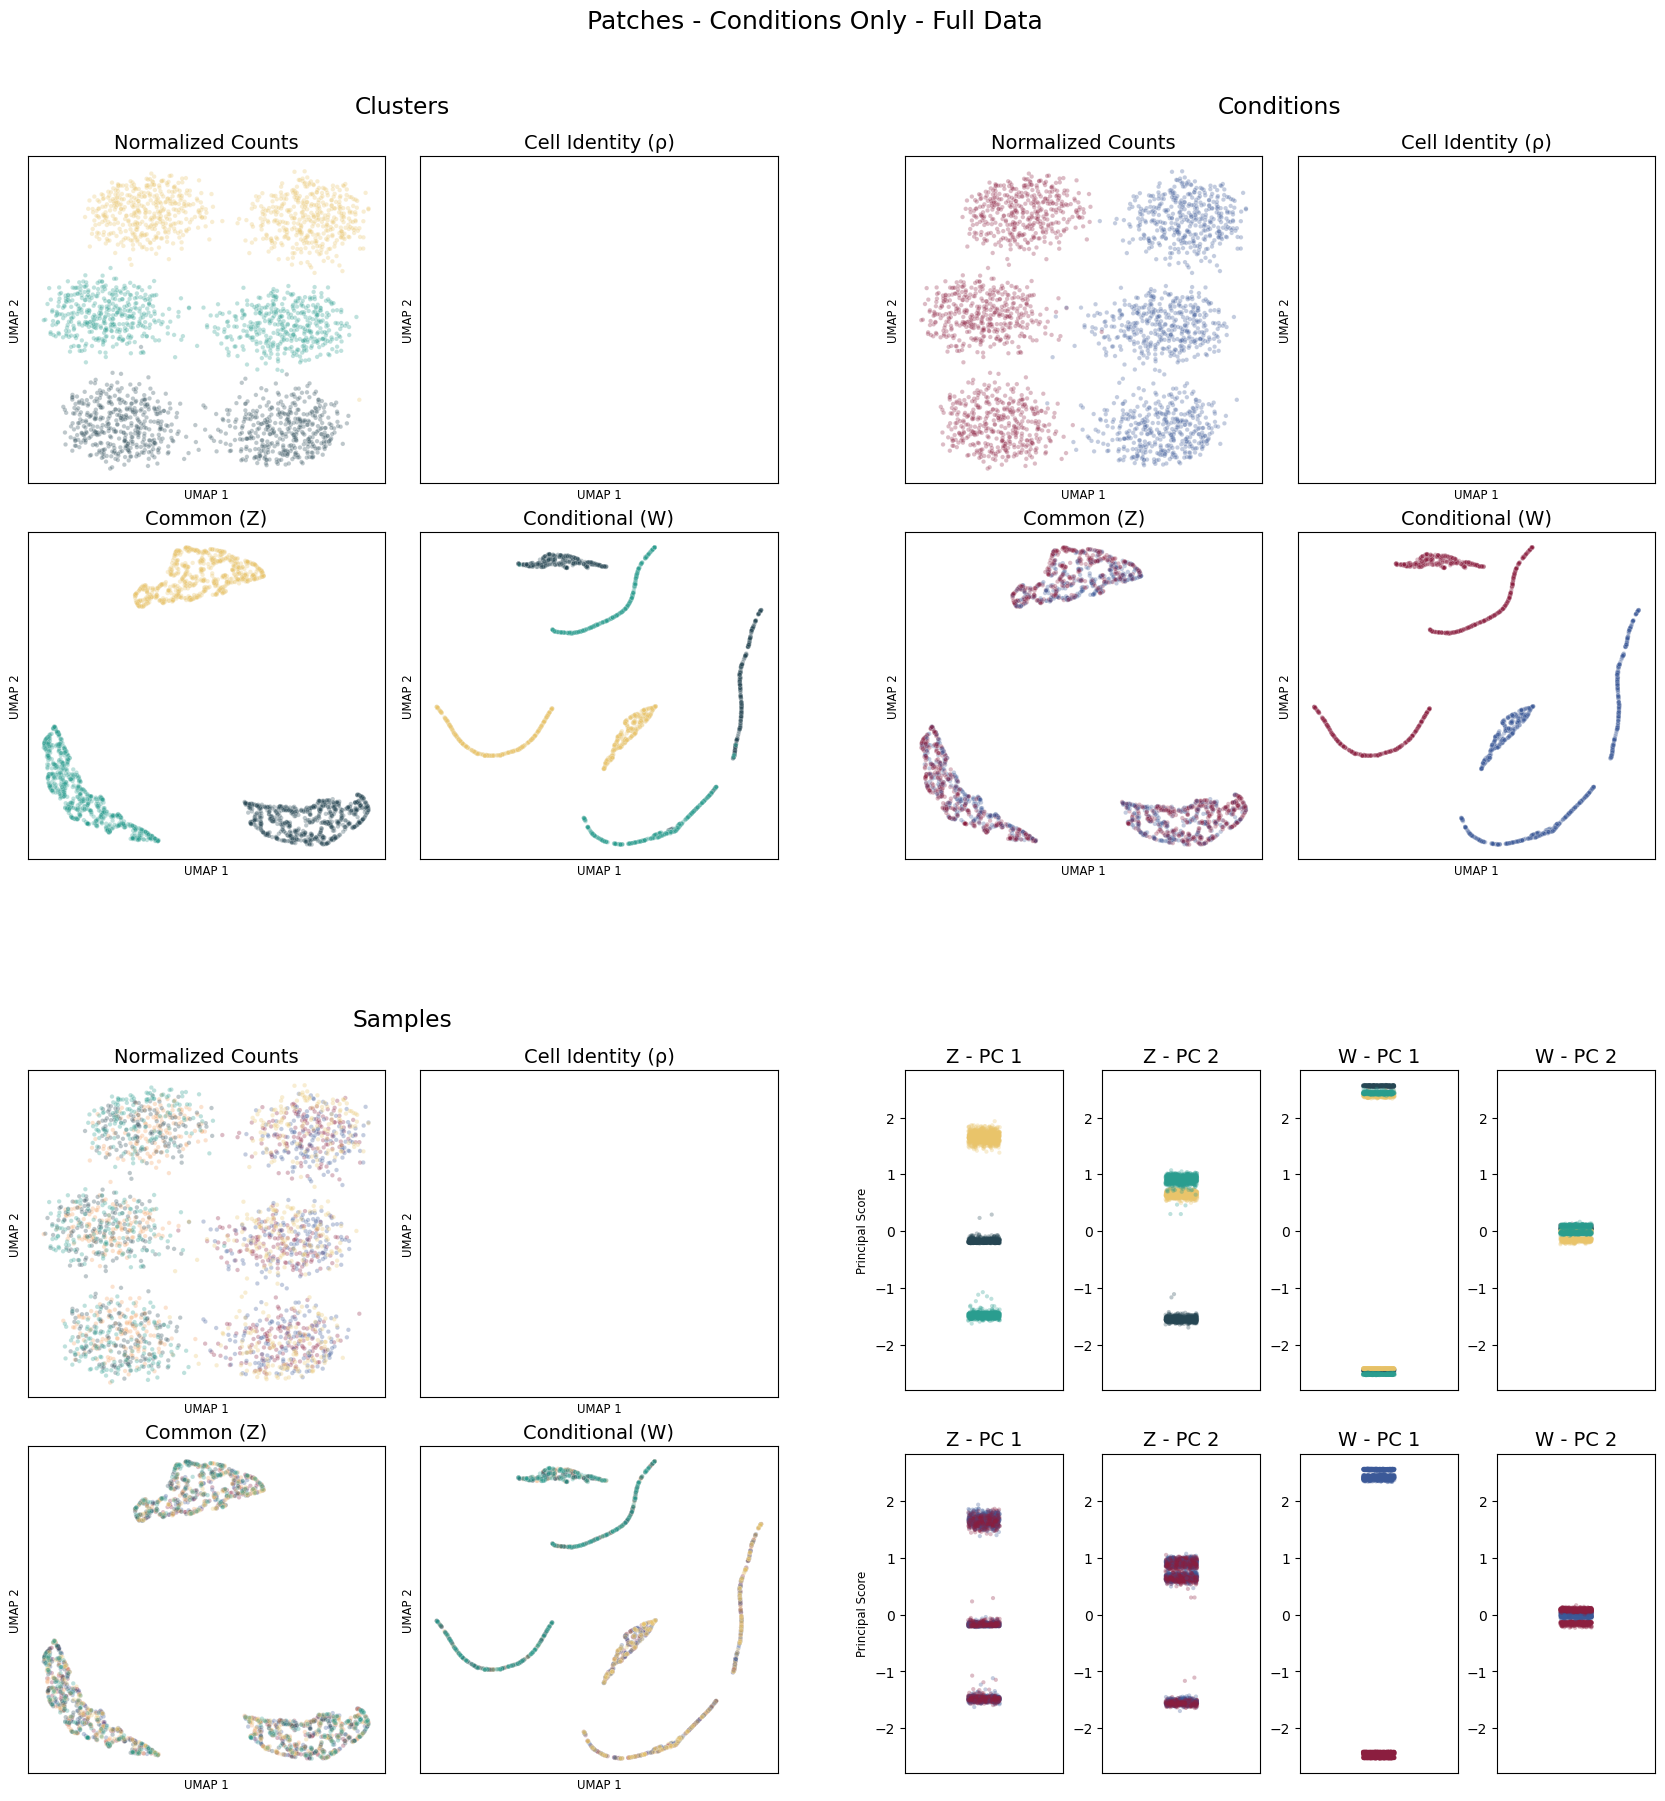

In [11]:
# Figure skeleton (adapted from Patches tutorial docs)


## create dataframes for plotting
df_patches = create_umap_df(workflow1, "Patches")
df_base = create_umap_df(workflow1, "Base")


## color palettes
klee_palette = [
    "#8B1E3F",  # Deep Burgundy
    "#3B5998",  # Rich Blue
    "#F4A261",  # Warm Orange
    "#264653",  # Deep Teal
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#D3D9E3",  # Soft Pastel Blue
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]

klee_palette_masch = [
    "#3B5998",  # Rich Blue
    "#6A994E",  # Fresh Olive Green
    "#F4A261",  # Warm Orange
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#FFC8A2",  # Soft Peach
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]


## plot parameters
fontsize=14
alpha=0.3
s=10
s_pca=3


## create a figure with a 2x2 grid of subplots
fig = plt.figure(figsize=(21, 21))

## define a GridSpec with a 2x2 layout
gs = gridspec.GridSpec(2, 2, wspace=0.17, hspace = 0.3, figure=fig)

## create subplots for the 2x2 grid
ax = [fig.add_subplot(gs[i//2, i%2]) for i in range(4)]

for subax in ax:
    subax.axis('off')

## define a new GridSpec for axis to split vertically
gs_inner_topleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 0], wspace=0.1, hspace=0.15)
gs_inner_topright = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 1], wspace=0.1, hspace=0.15)
gs_inner_botleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1, 0], wspace=0.1, hspace=0.15)
gs_inner_botright = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1, 1], wspace=0.25)

## create subplots for the inner grid
ax_inner_topleft = [fig.add_subplot(gs_inner_topleft[i//2, i%2]) for i in range(4)]
ax_inner_topright = [fig.add_subplot(gs_inner_topright[i//2, i%2]) for i in range(4)]
ax_inner_botleft = [fig.add_subplot(gs_inner_botleft[i//2, i%2]) for i in range(4)]

## specific for botright
ax_inner_botright = [fig.add_subplot(gs_inner_botright[0,0])]
ax_inner_botright = ax_inner_botright \
+ [
    fig.add_subplot(gs_inner_botright[0,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,3],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,0],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,3],sharey=ax_inner_botright[0]),
]


## UMAP plots

### counts
clu = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topright[0], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha)
con = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topleft[0], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha)
sam = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_botleft[0], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha)

### Zs
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topright[2], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topleft[2], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_botleft[2], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)

### Ws
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topright[3], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topleft[3], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_botleft[3], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)


## PCA plots

### cluster
sns.stripplot(df_patches, y = "z_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[0], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[0].axvline(zorder=2, color='black', linestyle = 'dashed')
    
sns.stripplot(df_patches, y = "z_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[1], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[1].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[2], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[2].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[3], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[3].axvline(zorder=2, color='black', linestyle = 'dashed')


### condition
sns.stripplot(df_patches, y = "z_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[4], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[4].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "z_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[5], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[5].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[6], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[6].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[7], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[7].axvline(zorder=2, color='black', linestyle = 'dashed')


## formatting

for subax in ax_inner_topright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_topleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_xlabel('')
    subax.set_ylabel('')

ax_inner_botright[0].set_ylabel('Principal Score', fontsize=fontsize*0.6)
ax_inner_botright[4].set_ylabel('Principal Score', fontsize=fontsize*0.6)

clu_h, clu_l = clu.get_legend_handles_labels() 
con_h, con_l = con.get_legend_handles_labels()
sam_h, sam_l = sam.get_legend_handles_labels()

clu.legend([], frameon=False); con.legend([], frameon=False); sam.legend([], frameon=False)

ax_inner_topleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_topright[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topright[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topright[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topright[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_botleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_botleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_botleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botright[0].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[1].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[2].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[3].set_title('W - PC 2', fontsize=fontsize)
ax_inner_botright[4].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[5].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[6].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[7].set_title('W - PC 2', fontsize=fontsize)


## set subplot titles
titles = ['Clusters', 'Conditions', 'Samples', '']

for a, t in zip(ax, titles):
    a.set_title(t, y=1.05, fontsize=fontsize*1.2)


## save and show figure
fig.suptitle("Patches - Conditions Only - Full Data", fontsize=18, y=0.95)
plt.savefig("../../outs/sim/t100,s80,b0-patches_con_full.png", dpi=300, bbox_inches='tight')
plt.show()

### HVG Data + Condtion (State) Only - Workflow2

In [12]:
# initialize workflow object
workflow2 = InterpretableWorkflow(
    adata_hvg.copy(),
    verbose=True,
    random_seed=random_seed
)

# define the condition classes & batch key to prepare the data
factors = ["group_id"]
workflow2.prep_model(
    factors,
    batch_key=batch_key,
    minibatch_size=minibatch_size_hvg,
    model_type="Patches",
    model_args={"ld_normalize" : True},
    optim_args={"lr" : lr_hvg})

# run model
workflow2.run_model(max_epochs=epochs_hvg, convergence_threshold=convergence_threshold, convergence_window=convergence_window)
workflow2.save_model("../../data/sim/02-scores_patches/t100,s80,b0-patches_con_hvg")

Initialized workflow to run interpretable model.

Condition classes : ['group_id']
Number of attributes per class : [2]

Initialized Patches model.
Model arguments: {'ld_normalize': True, 'reconstruction': 'ZINB_LD', 'batch_correction': True, 'scale_factor': 2.0833333333333333e-05, 'num_labels': 2, 'len_attrs': [2]}

Optimizer args parsed successfully. Final arguments: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optim_args': {'lr': 0.0065, 'eps': 0.01, 'betas': (0.9, 0.999)}, 'gamma': 1, 'milestones': [10000000000.0]}
Training initialized for a maximum of 2500, with convergence eps 0.0001.
Using device: cpu

Epoch : 0 || Train Loss: 70.19877 // 0.5324 || Test Loss: 9.91565 // 0.03389 || Warmup : False
Epoch : 1 || Train Loss: 8.86139 // 0.43829 || Test Loss: 7.67043 // 0.82631 || Warmup : False
Epoch : 2 || Train Loss: 7.44642 // 0.66761 || Test Loss: 6.95447 // 0.67696 || Warmup : False
Epoch : 3 || Train Loss: 6.61072 // 0.70313 || Test Loss: 6.28855 // 0.69813 || Warmup : False


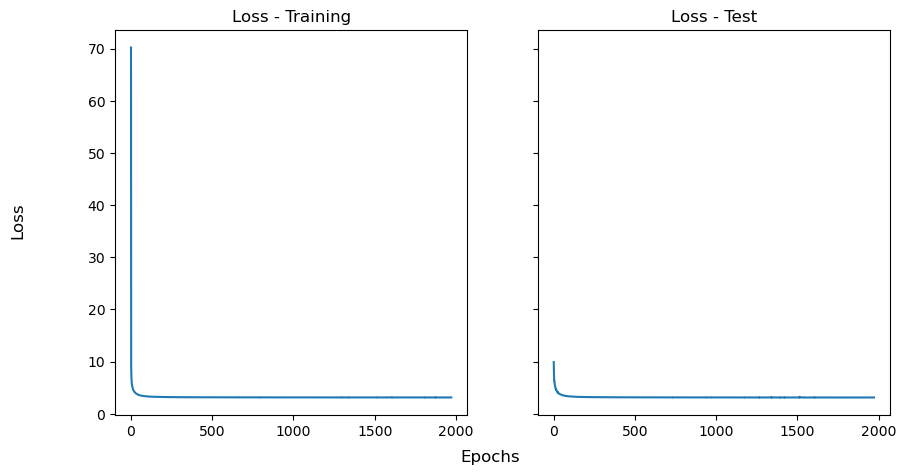

In [13]:
# inspect loss
workflow2.plot_loss()

In [14]:
# save embeddings to adata object
workflow2.write_embeddings()
workflow2.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: PCA, patches_w_latent, patches_z_latent

In [15]:
# evaluate run
workflow2.evaluate_reconstruction()

Calculating RMSE ...


100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


Calculating Profile Correlation ...


100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Calculating 2-Sliced Wasserstein ...


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Calculating Chamfer Discrepancy ...


100%|██████████| 5/5 [00:00<00:00, 308.34it/s]

Results
RMSE : 2.222 +- 0.164
Profile Correlation : 0.981 +- 0.002
2-Sliced Wasserstein : 21.556 +- 1.48
Chamfer Discrepancy : 19800.475 +- 178.861


{'RMSE': [np.float64(2.222), np.float64(0.164)],
 'Profile Correlation': [np.float64(0.981), np.float64(0.002)],
 '2-Sliced Wasserstein': [np.float64(21.556), np.float64(1.48)],
 'Chamfer Discrepancy': [np.float64(19800.475), np.float64(178.861)]}

In [16]:
# get loadings (gene scores)
workflow2.get_conditional_loadings()
workflow2.get_common_loadings()
workflow2.anndata.var

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


sample_1.Group1.Gene._  sample_1.Group1.GeneMean._  \
gene0001              gene_0001                    0.348913   
gene0002              gene_0002                    0.233752   
gene0003              gene_0003                    1.054020   
gene0004              gene_0004                    1.333374   
gene0006              gene_0006                    0.678394   
...                         ...                         ...   
gene1995              gene_1995                    0.041196   
gene1996              gene_1996                    5.450085   
gene1998              gene_1998                    3.358019   
gene1999              gene_1999                    1.414115   
gene2000              gene_2000                    0.033959   

         sample_2.Group1.Gene._  sample_2.Group1.GeneMean._  \
gene0001              gene_0001                    0.339048   
gene0002              gene_0002                    0.266857   
gene0003              gene_0003                    1.055463   
gene0004              gene_0004                    1.354434   
gene0006              gene_0006                    0.615692   
...                         ...                         ...   
gene1995              gene_1995                    0.041196   
gene1996              gene_1996                    5.842951   
gene1998              gene_1998                    2.716563   
gene1999              gene_1999                    1.194894   
gene2000              gene_2000                    0.036506   

         sample_3.Group1.Gene._  sample_3.Group1.GeneMean._  \
gene0001              gene_0001                    0.355008   
gene0002              gene_0002                    0.090465   
gene0003              gene_0003                    1.050622   
gene0004              gene_0004                    3.302799   
gene0006              gene_0006                    0.653093   
...                         ...                         ...   
gene1995              gene_1995                    0.014945   
gene1996              gene_1996                    2.373400   
gene1998              gene_1998                    3.271921   
gene1999              gene_1999                    1.214520   
gene2000              gene_2000                    0.032752   

         sample_4.Group1.Gene._  sample_4.Group1.GeneMean._  \
gene0001              gene_0001                    0.376501   
gene0002              gene_0002                    0.084239   
gene0003              gene_0003                    1.220659   
gene0004              gene_0004                    3.356972   
gene0006              gene_0006                    0.670220   
...                         ...                         ...   
gene1995              gene_1995                    0.014262   
gene1996              gene_1996                    2.211219   
gene1998              gene_1998                    3.314637   
gene1999              gene_1999                    1.187953   
gene2000              gene_2000                    0.034540   

         sample_5.Group1.Gene._  sample_5.Group1.GeneMean._  ...  \
gene0001              gene_0001                    0.318932  ...   
gene0002              gene_0002                    0.262775  ...   
gene0003              gene_0003                    1.215103  ...   
gene0004              gene_0004                    1.311693  ...   
gene0006              gene_0006                    0.631826  ...   
...                         ...                         ...  ...   
gene1995              gene_1995                    0.038419  ...   
gene1996              gene_1996                    5.734554  ...   
gene1998              gene_1998                    3.261122  ...   
gene1999              gene_1999                    1.102327  ...   
gene2000              gene_2000                    0.031469  ...   

         cvQuantileNorm   gene_id       bio  highly_variable     means  \
gene0001       0.055493  gene0001  0.000427             True  3.131532   
gene0002       0

In [17]:
# save loadings to file
workflow2.anndata.var.loc[:, ["Condition1_score_Patches", "Condition2_score_Patches", "common_score_Patches"]].to_csv(
    "../../data/sim/02-scores_patches/t100,s80,b0-patches_con_hvg_loadings.csv"
)

/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


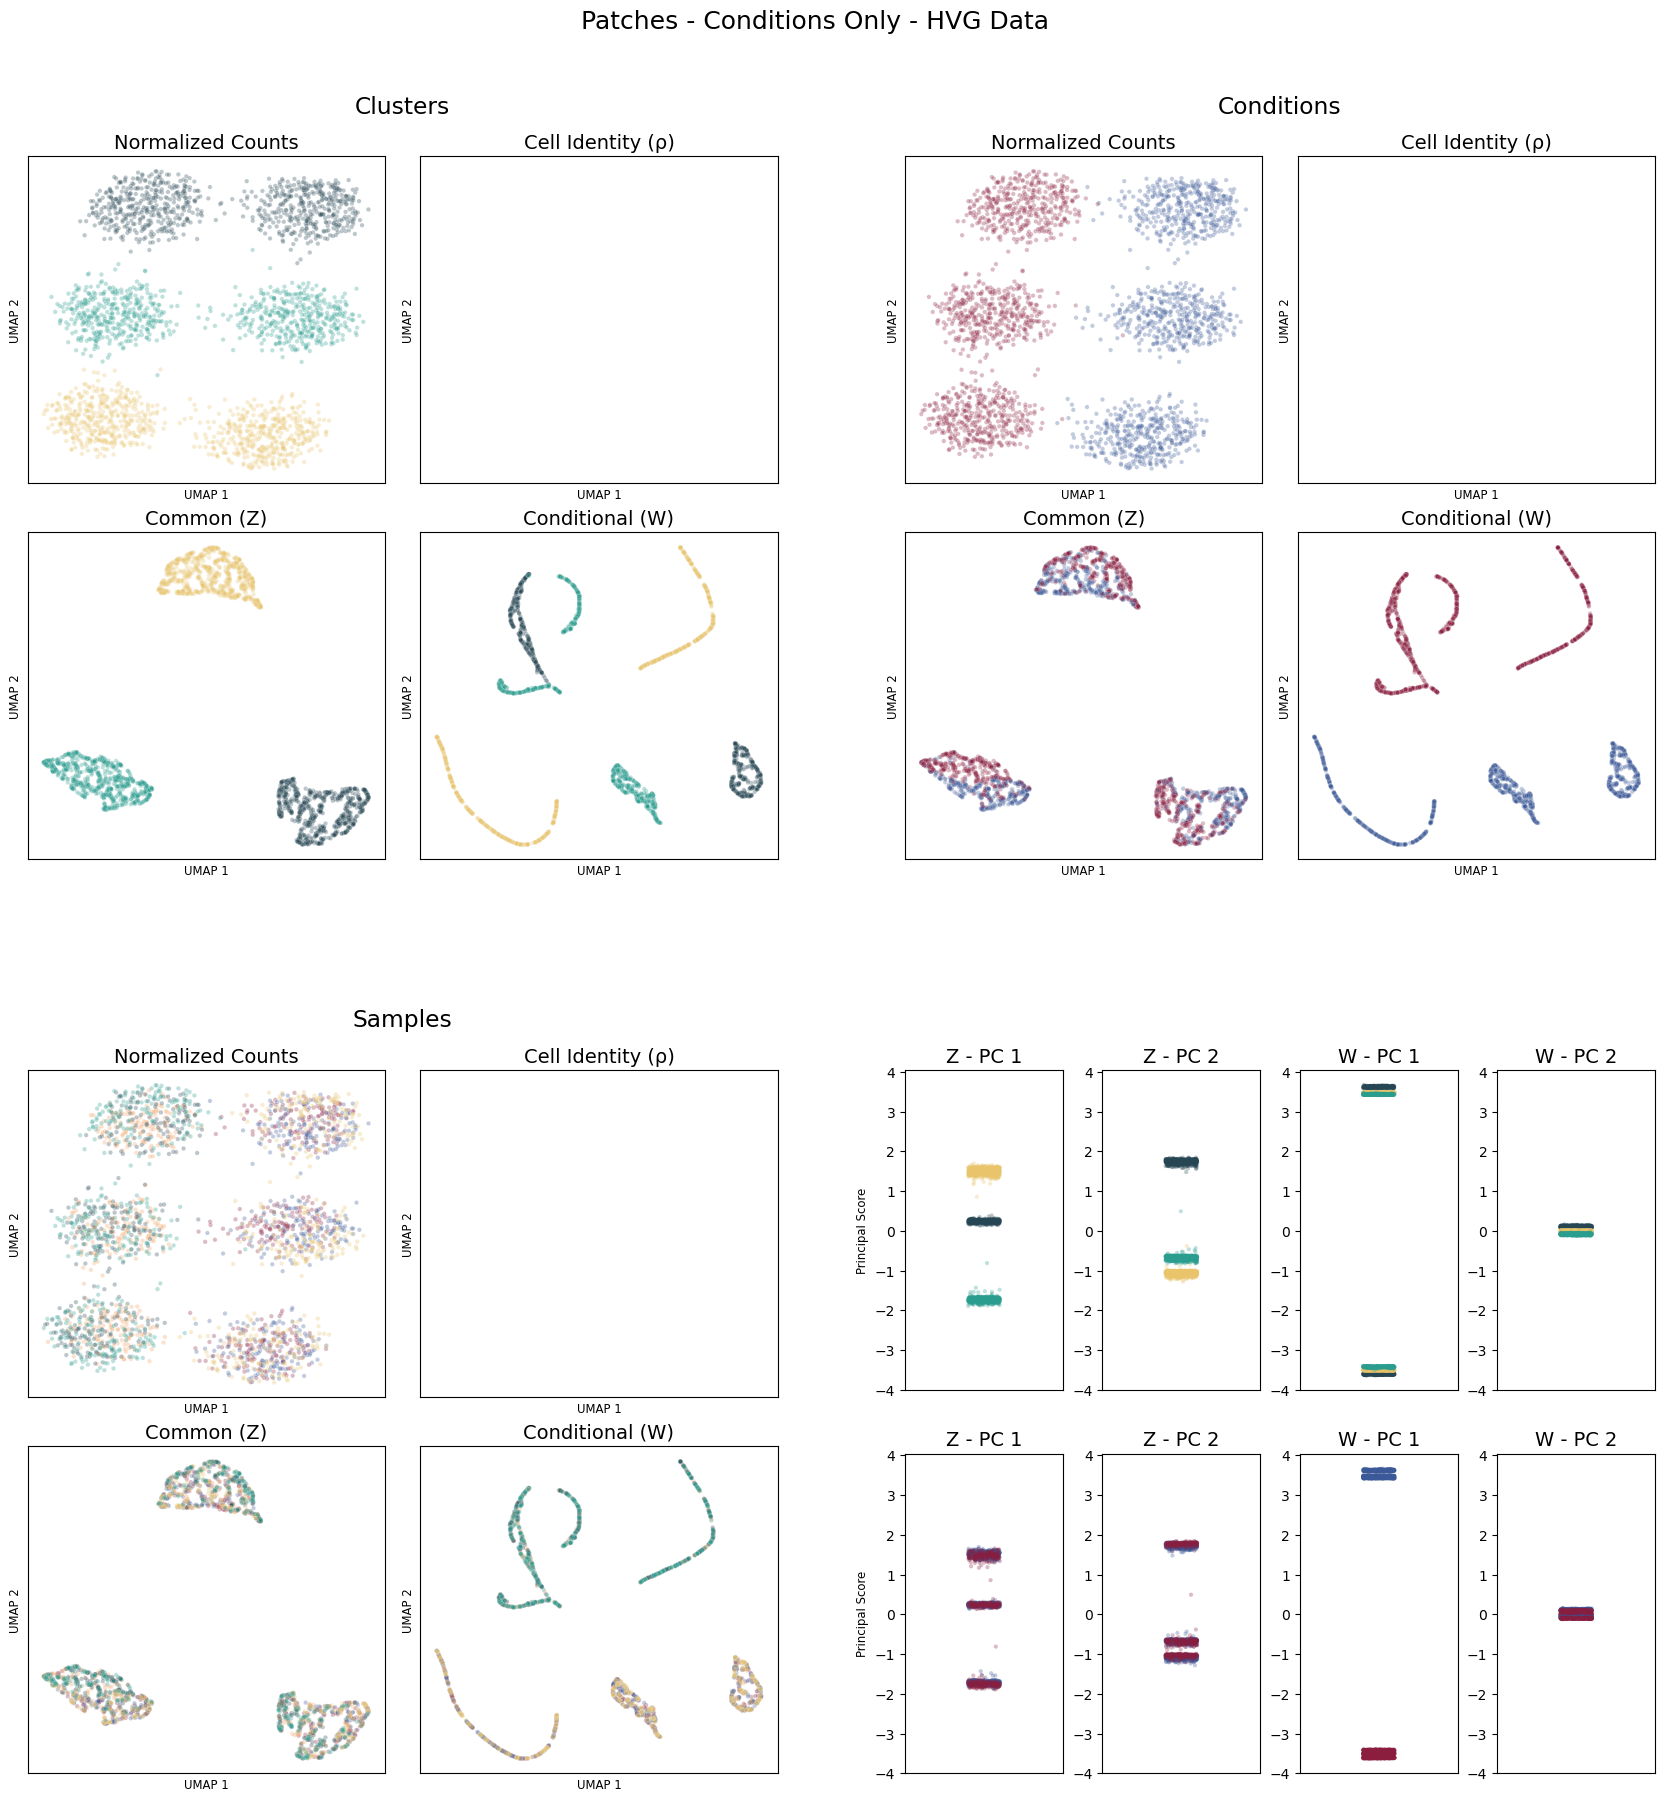

In [18]:
# Figure skeleton (adapted from Patches tutorial docs)


## create dataframes for plotting
df_patches = create_umap_df(workflow2, "Patches")
df_base = create_umap_df(workflow2, "Base")


## color palettes
klee_palette = [
    "#8B1E3F",  # Deep Burgundy
    "#3B5998",  # Rich Blue
    "#F4A261",  # Warm Orange
    "#264653",  # Deep Teal
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#D3D9E3",  # Soft Pastel Blue
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]

klee_palette_masch = [
    "#3B5998",  # Rich Blue
    "#6A994E",  # Fresh Olive Green
    "#F4A261",  # Warm Orange
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#FFC8A2",  # Soft Peach
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]


## plot parameters
fontsize=14
alpha=0.3
s=10
s_pca=3


## create a figure with a 2x2 grid of subplots
fig = plt.figure(figsize=(21, 21))

## define a GridSpec with a 2x2 layout
gs = gridspec.GridSpec(2, 2, wspace=0.17, hspace = 0.3, figure=fig)

## create subplots for the 2x2 grid
ax = [fig.add_subplot(gs[i//2, i%2]) for i in range(4)]

for subax in ax:
    subax.axis('off')

## define a new GridSpec for axis to split vertically
gs_inner_topleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 0], wspace=0.1, hspace=0.15)
gs_inner_topright = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 1], wspace=0.1, hspace=0.15)
gs_inner_botleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1, 0], wspace=0.1, hspace=0.15)
gs_inner_botright = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1, 1], wspace=0.25)

## create subplots for the inner grid
ax_inner_topleft = [fig.add_subplot(gs_inner_topleft[i//2, i%2]) for i in range(4)]
ax_inner_topright = [fig.add_subplot(gs_inner_topright[i//2, i%2]) for i in range(4)]
ax_inner_botleft = [fig.add_subplot(gs_inner_botleft[i//2, i%2]) for i in range(4)]

## specific for botright
ax_inner_botright = [fig.add_subplot(gs_inner_botright[0,0])]
ax_inner_botright = ax_inner_botright \
+ [
    fig.add_subplot(gs_inner_botright[0,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,3],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,0],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,3],sharey=ax_inner_botright[0]),
]


## UMAP plots

### counts
clu = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topright[0], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha)
con = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topleft[0], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha)
sam = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_botleft[0], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha)

### Zs
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topright[2], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topleft[2], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_botleft[2], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)

### Ws
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topright[3], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topleft[3], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_botleft[3], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)


## PCA plots

### cluster
sns.stripplot(df_patches, y = "z_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[0], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[0].axvline(zorder=2, color='black', linestyle = 'dashed')
    
sns.stripplot(df_patches, y = "z_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[1], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[1].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[2], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[2].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[3], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[3].axvline(zorder=2, color='black', linestyle = 'dashed')


### condition
sns.stripplot(df_patches, y = "z_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[4], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[4].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "z_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[5], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[5].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[6], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[6].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[7], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[7].axvline(zorder=2, color='black', linestyle = 'dashed')


## formatting

for subax in ax_inner_topright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_topleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_xlabel('')
    subax.set_ylabel('')

ax_inner_botright[0].set_ylabel('Principal Score', fontsize=fontsize*0.6)
ax_inner_botright[4].set_ylabel('Principal Score', fontsize=fontsize*0.6)

clu_h, clu_l = clu.get_legend_handles_labels() 
con_h, con_l = con.get_legend_handles_labels()
sam_h, sam_l = sam.get_legend_handles_labels()

clu.legend([], frameon=False); con.legend([], frameon=False); sam.legend([], frameon=False)

ax_inner_topleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_topright[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topright[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topright[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topright[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_botleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_botleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_botleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botright[0].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[1].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[2].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[3].set_title('W - PC 2', fontsize=fontsize)
ax_inner_botright[4].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[5].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[6].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[7].set_title('W - PC 2', fontsize=fontsize)


## set subplot titles
titles = ['Clusters', 'Conditions', 'Samples', '']

for a, t in zip(ax, titles):
    a.set_title(t, y=1.05, fontsize=fontsize*1.2)


## save and show figure
fig.suptitle("Patches - Conditions Only - HVG Data", fontsize=18, y=0.95)
plt.savefig("../../outs/sim/t100,s80,b0-patches_con_hvg.png", dpi=300, bbox_inches='tight')
plt.show()

### Full Data + Cluster (Type) & Condtion (State) - Workflow3

In [19]:
# initialize workflow object
workflow3 = InterpretableWorkflow(
    adata_full.copy(),
    verbose=True,
    random_seed=random_seed
)

# define the condition classes & batch key to prepare the data
factors = ["cluster_id", "group_id"]
workflow3.prep_model(
    factors,
    batch_key=batch_key,
    minibatch_size=minibatch_size_full,
    model_type="Patches",
    model_args={"ld_normalize" : True},
    optim_args={"lr" : lr_full})

# run model
workflow3.run_model(max_epochs=epochs_full, convergence_threshold=convergence_threshold, convergence_window=convergence_window)
workflow3.save_model("../../data/sim/02-scores_patches/t100,s80,b0-patches_clu_con_full")

Initialized workflow to run interpretable model.

Condition classes : ['cluster_id', 'group_id']
Number of attributes per class : [3, 2]

Initialized Patches model.
Model arguments: {'ld_normalize': True, 'reconstruction': 'ZINB_LD', 'batch_correction': True, 'scale_factor': 1.579080343607883e-05, 'num_labels': 5, 'len_attrs': [3, 2]}

Optimizer args parsed successfully. Final arguments: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optim_args': {'lr': 0.0098, 'eps': 0.01, 'betas': (0.9, 0.999)}, 'gamma': 1, 'milestones': [10000000000.0]}
Training initialized for a maximum of 1500, with convergence eps 0.0001.
Using device: cpu

Epoch : 0 || Train Loss: 57.57623 // 1.86014 || Test Loss: 14.16847 // 1.79358 || Warmup : False
Epoch : 1 || Train Loss: 9.33155 // 1.86224 || Test Loss: 6.97642 // 1.83369 || Warmup : False
Epoch : 2 || Train Loss: 6.98438 // 1.83271 || Test Loss: 6.21905 // 1.83239 || Warmup : False
Epoch : 3 || Train Loss: 6.10651 // 1.85213 || Test Loss: 5.90438 // 1.869

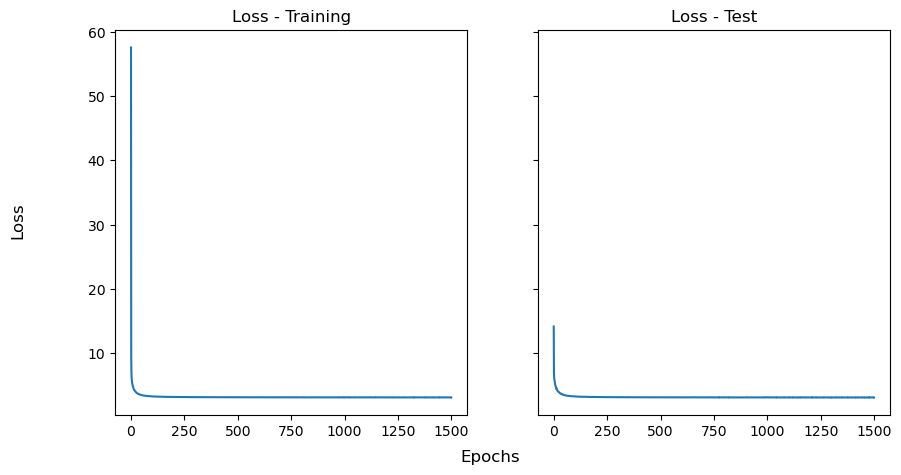

In [20]:
# inspect loss
workflow3.plot_loss()

In [21]:
# save embeddings to adata object
workflow3.write_embeddings()
workflow3.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: PCA, patches_w_latent, patches_z_latent

In [22]:
# evaluate run
workflow3.evaluate_reconstruction()

Calculating RMSE ...


100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Calculating Profile Correlation ...


100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Calculating 2-Sliced Wasserstein ...


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Calculating Chamfer Discrepancy ...


100%|██████████| 5/5 [00:00<00:00, 196.27it/s]

Results
RMSE : 3.271 +- 0.082
Profile Correlation : 0.893 +- 0.006
2-Sliced Wasserstein : 26.205 +- 1.316
Chamfer Discrepancy : 19744.26 +- 748.112


{'RMSE': [np.float64(3.271), np.float64(0.082)],
 'Profile Correlation': [np.float64(0.893), np.float64(0.006)],
 '2-Sliced Wasserstein': [np.float64(26.205), np.float64(1.316)],
 'Chamfer Discrepancy': [np.float64(19744.26), np.float64(748.112)]}

In [23]:
# get loadings (gene scores)
workflow3.get_conditional_loadings()
workflow3.get_common_loadings()
workflow3.anndata.var

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


sample_1.Group1.Gene._  sample_1.Group1.GeneMean._  \
gene0001              gene_0001                    0.348913   
gene0002              gene_0002                    0.233752   
gene0003              gene_0003                    1.054020   
gene0004              gene_0004                    1.333374   
gene0005              gene_0005                    0.359099   
...                         ...                         ...   
gene1996              gene_1996                    5.450085   
gene1997              gene_1997                    3.712653   
gene1998              gene_1998                    3.358019   
gene1999              gene_1999                    1.414115   
gene2000              gene_2000                    0.033959   

         sample_2.Group1.Gene._  sample_2.Group1.GeneMean._  \
gene0001              gene_0001                    0.339048   
gene0002              gene_0002                    0.266857   
gene0003              gene_0003                    1.055463   
gene0004              gene_0004                    1.354434   
gene0005              gene_0005                    0.359099   
...                         ...                         ...   
gene1996              gene_1996                    5.842951   
gene1997              gene_1997                    4.112237   
gene1998              gene_1998                    2.716563   
gene1999              gene_1999                    1.194894   
gene2000              gene_2000                    0.036506   

         sample_3.Group1.Gene._  sample_3.Group1.GeneMean._  \
gene0001              gene_0001                    0.355008   
gene0002              gene_0002                    0.090465   
gene0003              gene_0003                    1.050622   
gene0004              gene_0004                    3.302799   
gene0005              gene_0005                    0.336419   
...                         ...                         ...   
gene1996              gene_1996                    2.373400   
gene1997              gene_1997                    4.176653   
gene1998              gene_1998                    3.271921   
gene1999              gene_1999                    1.214520   
gene2000              gene_2000                    0.032752   

         sample_4.Group1.Gene._  sample_4.Group1.GeneMean._  \
gene0001              gene_0001                    0.376501   
gene0002              gene_0002                    0.084239   
gene0003              gene_0003                    1.220659   
gene0004              gene_0004                    3.356972   
gene0005              gene_0005                    0.365225   
...                         ...                         ...   
gene1996              gene_1996                    2.211219   
gene1997              gene_1997                    4.402447   
gene1998              gene_1998                    3.314637   
gene1999              gene_1999                    1.187953   
gene2000              gene_2000                    0.034540   

         sample_5.Group1.Gene._  sample_5.Group1.GeneMean._  ...  \
gene0001              gene_0001                    0.318932  ...   
gene0002              gene_0002                    0.262775  ...   
gene0003              gene_0003                    1.215103  ...   
gene0004              gene_0004                    1.311693  ...   
gene0005              gene_0005                    0.338109  ...   
...                         ...                         ...  ...   
gene1996              gene_1996                    5.734554  ...   
gene1997              gene_1997                    4.342350  ...   
gene1998              gene_1998                    3.261122  ...   
gene1999              gene_1999                    1.102327  ...   
gene2000              gene_2000                    0.031469  ...   

         meanQuantileNorm  cvQuantileNorm   gene_id       bio  \
gene0001         0.349444        0.055493  gene0001  0.000427   
gene0002         0.090716        0

In [24]:
# save loadings to file
workflow3.anndata.var.loc[:, ["Group1_score_Patches", "Group2_score_Patches", "Group3_score_Patches", "Condition1_score_Patches", "Condition2_score_Patches", "common_score_Patches"]].to_csv(
    "../../data/sim/02-scores_patches/t100,s80,b0-patches_clu_con_full_loadings.csv"
)

/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


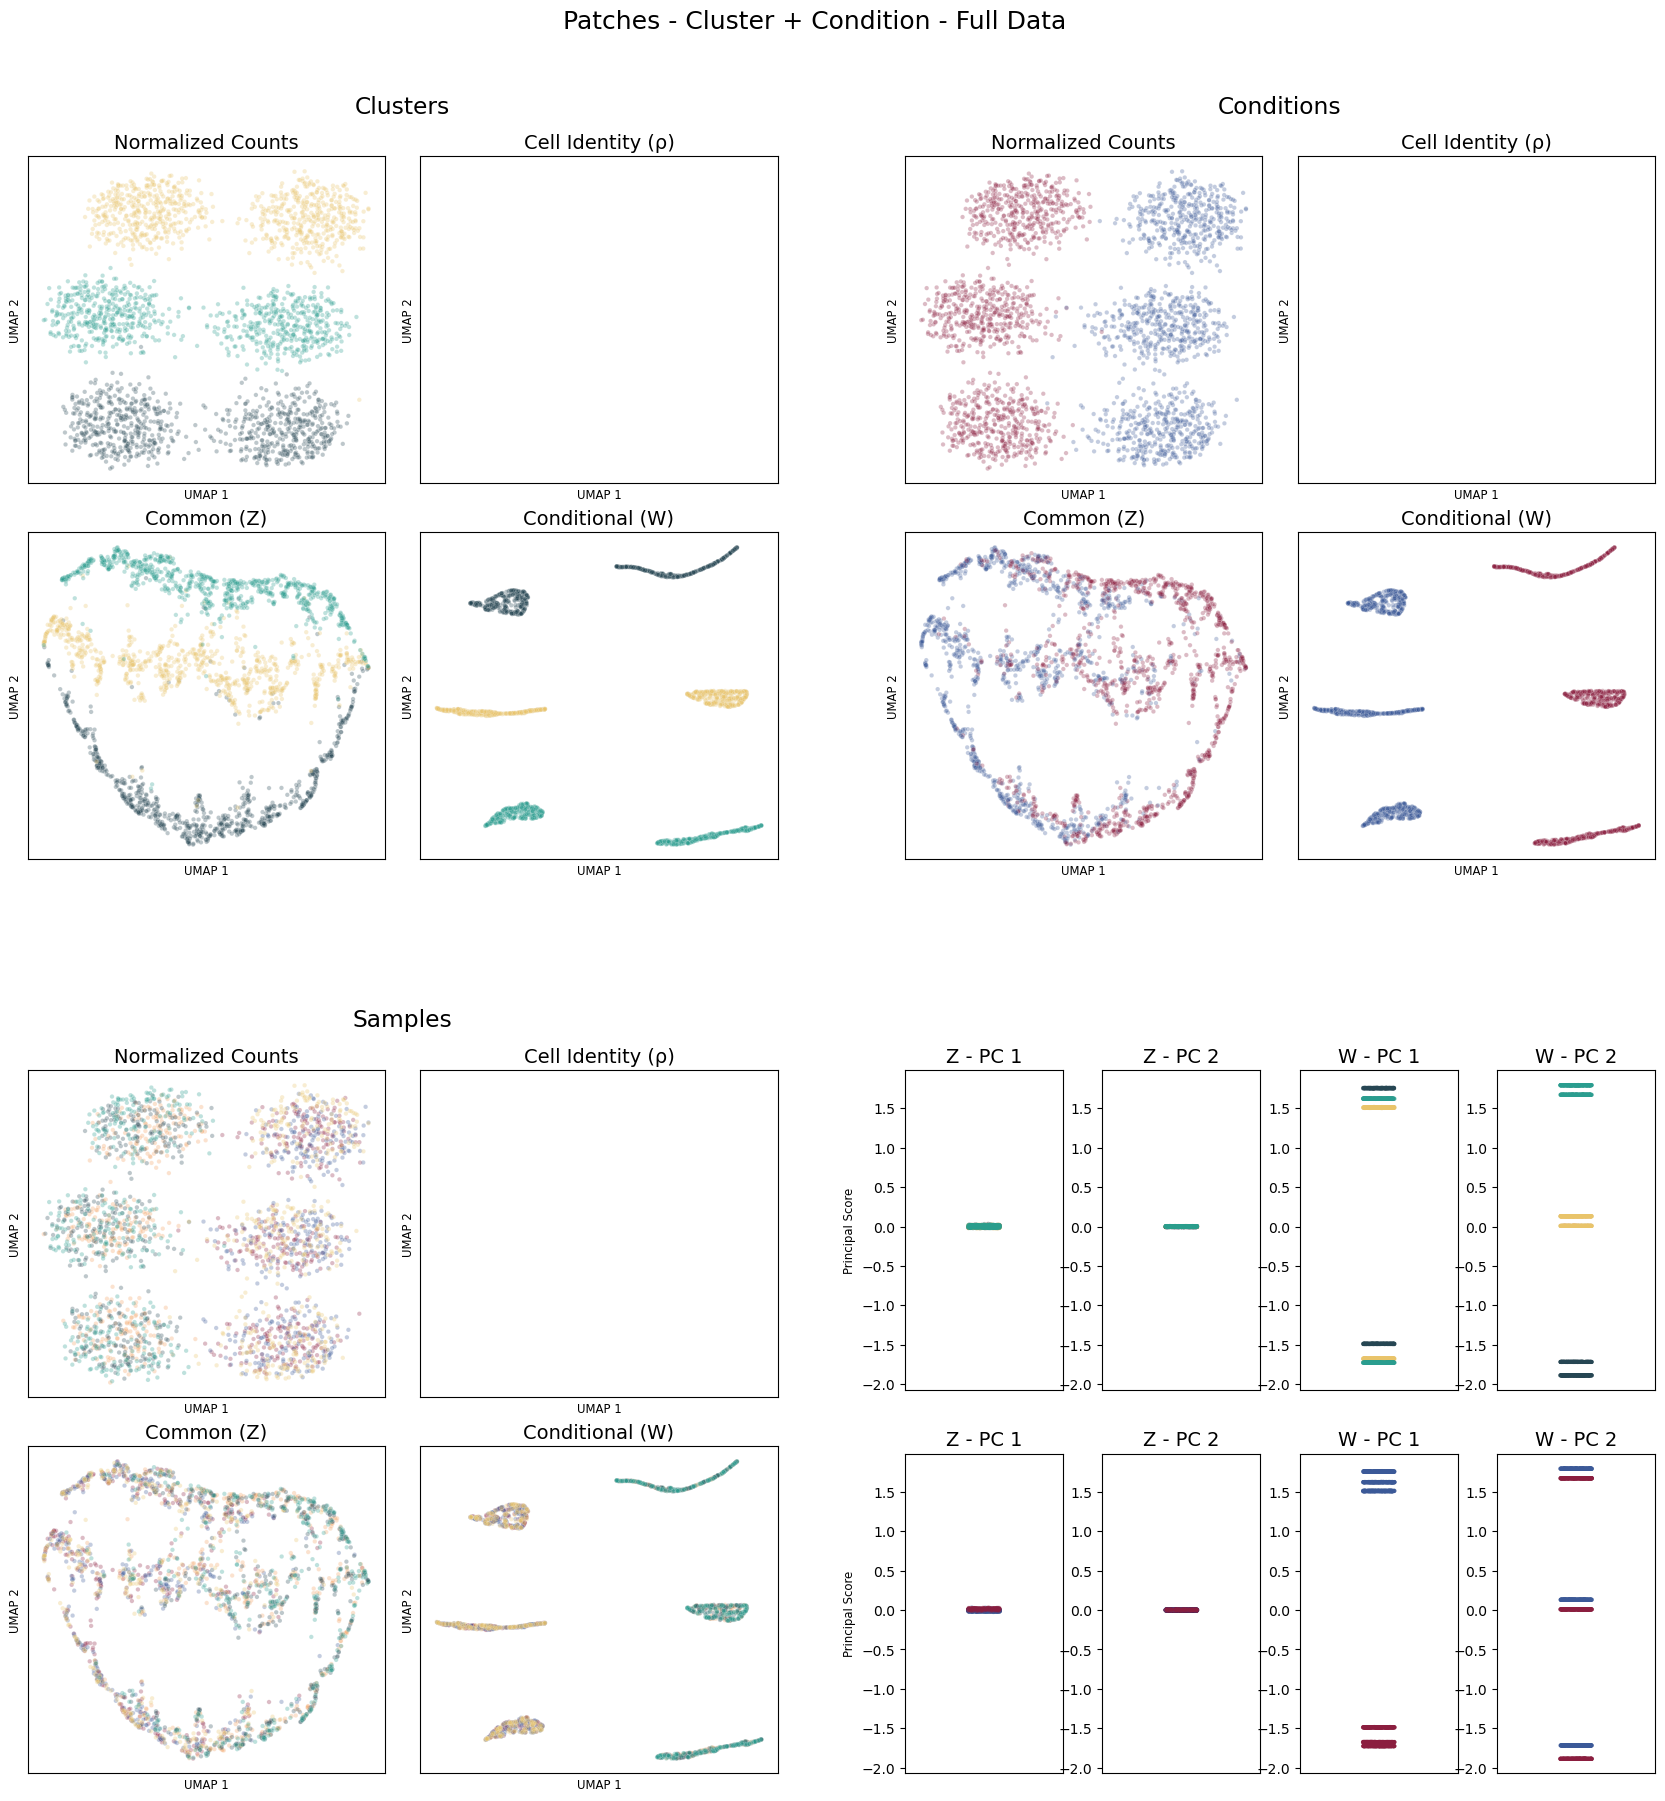

In [25]:
# Figure skeleton (adapted from Patches tutorial docs)


## create dataframes for plotting
df_patches = create_umap_df(workflow3, "Patches")
df_base = create_umap_df(workflow3, "Base")


## color palettes
klee_palette = [
    "#8B1E3F",  # Deep Burgundy
    "#3B5998",  # Rich Blue
    "#F4A261",  # Warm Orange
    "#264653",  # Deep Teal
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#D3D9E3",  # Soft Pastel Blue
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]

klee_palette_masch = [
    "#3B5998",  # Rich Blue
    "#6A994E",  # Fresh Olive Green
    "#F4A261",  # Warm Orange
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#FFC8A2",  # Soft Peach
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]


## plot parameters
fontsize=14
alpha=0.3
s=10
s_pca=3


## create a figure with a 2x2 grid of subplots
fig = plt.figure(figsize=(21, 21))

## define a GridSpec with a 2x2 layout
gs = gridspec.GridSpec(2, 2, wspace=0.17, hspace = 0.3, figure=fig)

## create subplots for the 2x2 grid
ax = [fig.add_subplot(gs[i//2, i%2]) for i in range(4)]

for subax in ax:
    subax.axis('off')

## define a new GridSpec for axis to split vertically
gs_inner_topleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 0], wspace=0.1, hspace=0.15)
gs_inner_topright = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 1], wspace=0.1, hspace=0.15)
gs_inner_botleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1, 0], wspace=0.1, hspace=0.15)
gs_inner_botright = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1, 1], wspace=0.25)

## create subplots for the inner grid
ax_inner_topleft = [fig.add_subplot(gs_inner_topleft[i//2, i%2]) for i in range(4)]
ax_inner_topright = [fig.add_subplot(gs_inner_topright[i//2, i%2]) for i in range(4)]
ax_inner_botleft = [fig.add_subplot(gs_inner_botleft[i//2, i%2]) for i in range(4)]

## specific for botright
ax_inner_botright = [fig.add_subplot(gs_inner_botright[0,0])]
ax_inner_botright = ax_inner_botright \
+ [
    fig.add_subplot(gs_inner_botright[0,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,3],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,0],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,3],sharey=ax_inner_botright[0]),
]


## UMAP plots

### counts
clu = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topright[0], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha)
con = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topleft[0], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha)
sam = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_botleft[0], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha)

### Zs
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topright[2], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topleft[2], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_botleft[2], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)

### Ws
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topright[3], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topleft[3], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_botleft[3], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)


## PCA plots

### cluster
sns.stripplot(df_patches, y = "z_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[0], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[0].axvline(zorder=2, color='black', linestyle = 'dashed')
    
sns.stripplot(df_patches, y = "z_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[1], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[1].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[2], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[2].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[3], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[3].axvline(zorder=2, color='black', linestyle = 'dashed')


### condition
sns.stripplot(df_patches, y = "z_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[4], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[4].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "z_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[5], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[5].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[6], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[6].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[7], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[7].axvline(zorder=2, color='black', linestyle = 'dashed')


## formatting

for subax in ax_inner_topright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_topleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_xlabel('')
    subax.set_ylabel('')

ax_inner_botright[0].set_ylabel('Principal Score', fontsize=fontsize*0.6)
ax_inner_botright[4].set_ylabel('Principal Score', fontsize=fontsize*0.6)

clu_h, clu_l = clu.get_legend_handles_labels() 
con_h, con_l = con.get_legend_handles_labels()
sam_h, sam_l = sam.get_legend_handles_labels()

clu.legend([], frameon=False); con.legend([], frameon=False); sam.legend([], frameon=False)

ax_inner_topleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_topright[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topright[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topright[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topright[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_botleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_botleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_botleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botright[0].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[1].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[2].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[3].set_title('W - PC 2', fontsize=fontsize)
ax_inner_botright[4].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[5].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[6].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[7].set_title('W - PC 2', fontsize=fontsize)


## set subplot titles
titles = ['Clusters', 'Conditions', 'Samples', '']

for a, t in zip(ax, titles):
    a.set_title(t, y=1.05, fontsize=fontsize*1.2)

    
## save and show figure
fig.suptitle("Patches - Cluster + Condition - Full Data", fontsize=18, y=0.95)
plt.savefig("../../outs/sim/t100,s80,b0-patches_clu_con_full.png", dpi=300, bbox_inches='tight')
plt.show()

### HVG Data + Cluster (Type) & Condtion (State) - Workflow4

In [26]:
# initialize workflow object
workflow4 = InterpretableWorkflow(
    adata_hvg.copy(),
    verbose=True,
    random_seed=random_seed
)

# define the condition classes & batch key to prepare the data
factors = ["cluster_id", "group_id"]
workflow4.prep_model(
    factors,
    batch_key=batch_key,
    minibatch_size=minibatch_size_hvg,
    model_type="Patches",
    model_args={"ld_normalize" : True},
    optim_args={"lr" : lr_hvg})

# run model
workflow4.run_model(max_epochs=epochs_hvg, convergence_threshold=convergence_threshold, convergence_window=convergence_window)
workflow4.save_model("../../data/sim/02-scores_patches/t100,s80,b0-patches_clu_con_hvg")

Initialized workflow to run interpretable model.

Condition classes : ['cluster_id', 'group_id']
Number of attributes per class : [3, 2]

Initialized Patches model.
Model arguments: {'ld_normalize': True, 'reconstruction': 'ZINB_LD', 'batch_correction': True, 'scale_factor': 2.0833333333333333e-05, 'num_labels': 5, 'len_attrs': [3, 2]}

Optimizer args parsed successfully. Final arguments: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optim_args': {'lr': 0.0065, 'eps': 0.01, 'betas': (0.9, 0.999)}, 'gamma': 1, 'milestones': [10000000000.0]}
Training initialized for a maximum of 2500, with convergence eps 0.0001.
Using device: cpu

Epoch : 0 || Train Loss: 69.94272 // 1.61642 || Test Loss: 12.67183 // 1.7176 || Warmup : False
Epoch : 1 || Train Loss: 9.3064 // 1.78323 || Test Loss: 7.42927 // 1.7589 || Warmup : False
Epoch : 2 || Train Loss: 7.2227 // 1.81753 || Test Loss: 6.53902 // 1.78568 || Warmup : False
Epoch : 3 || Train Loss: 6.40073 // 1.82514 || Test Loss: 6.42309 // 1.80593 

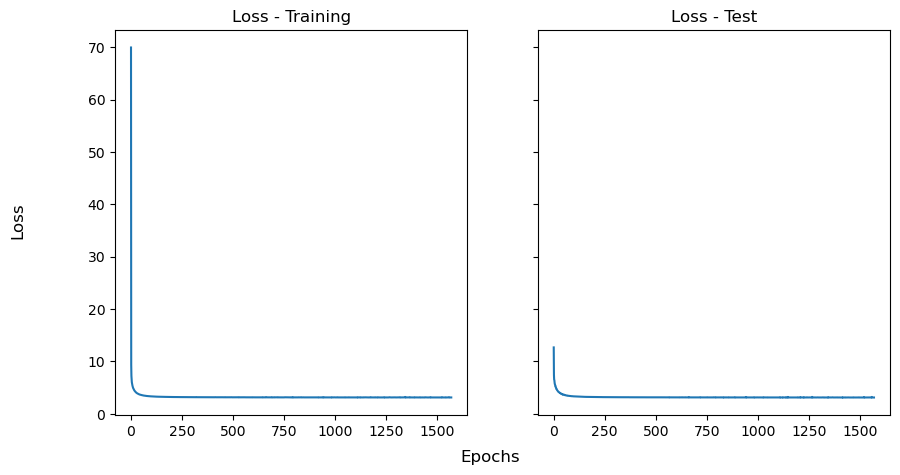

In [27]:
# inspect loss
workflow4.plot_loss()

In [28]:
# save embeddings to adata object
workflow4.write_embeddings()
workflow4.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: PCA, patches_w_latent, patches_z_latent

In [29]:
# evaluate run
workflow4.evaluate_reconstruction()

Calculating RMSE ...


100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


Calculating Profile Correlation ...


100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


Calculating 2-Sliced Wasserstein ...


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Calculating Chamfer Discrepancy ...


100%|██████████| 5/5 [00:00<00:00, 266.33it/s]

Results
RMSE : 1.976 +- 0.078
Profile Correlation : 0.983 +- 0.001
2-Sliced Wasserstein : 22.38 +- 1.811
Chamfer Discrepancy : 18820.885 +- 246.757


{'RMSE': [np.float64(1.976), np.float64(0.078)],
 'Profile Correlation': [np.float64(0.983), np.float64(0.001)],
 '2-Sliced Wasserstein': [np.float64(22.38), np.float64(1.811)],
 'Chamfer Discrepancy': [np.float64(18820.885), np.float64(246.757)]}

In [30]:
# get loadings (gene scores)
workflow4.get_conditional_loadings()
workflow4.get_common_loadings()
workflow4.anndata.var

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


sample_1.Group1.Gene._  sample_1.Group1.GeneMean._  \
gene0001              gene_0001                    0.348913   
gene0002              gene_0002                    0.233752   
gene0003              gene_0003                    1.054020   
gene0004              gene_0004                    1.333374   
gene0006              gene_0006                    0.678394   
...                         ...                         ...   
gene1995              gene_1995                    0.041196   
gene1996              gene_1996                    5.450085   
gene1998              gene_1998                    3.358019   
gene1999              gene_1999                    1.414115   
gene2000              gene_2000                    0.033959   

         sample_2.Group1.Gene._  sample_2.Group1.GeneMean._  \
gene0001              gene_0001                    0.339048   
gene0002              gene_0002                    0.266857   
gene0003              gene_0003                    1.055463   
gene0004              gene_0004                    1.354434   
gene0006              gene_0006                    0.615692   
...                         ...                         ...   
gene1995              gene_1995                    0.041196   
gene1996              gene_1996                    5.842951   
gene1998              gene_1998                    2.716563   
gene1999              gene_1999                    1.194894   
gene2000              gene_2000                    0.036506   

         sample_3.Group1.Gene._  sample_3.Group1.GeneMean._  \
gene0001              gene_0001                    0.355008   
gene0002              gene_0002                    0.090465   
gene0003              gene_0003                    1.050622   
gene0004              gene_0004                    3.302799   
gene0006              gene_0006                    0.653093   
...                         ...                         ...   
gene1995              gene_1995                    0.014945   
gene1996              gene_1996                    2.373400   
gene1998              gene_1998                    3.271921   
gene1999              gene_1999                    1.214520   
gene2000              gene_2000                    0.032752   

         sample_4.Group1.Gene._  sample_4.Group1.GeneMean._  \
gene0001              gene_0001                    0.376501   
gene0002              gene_0002                    0.084239   
gene0003              gene_0003                    1.220659   
gene0004              gene_0004                    3.356972   
gene0006              gene_0006                    0.670220   
...                         ...                         ...   
gene1995              gene_1995                    0.014262   
gene1996              gene_1996                    2.211219   
gene1998              gene_1998                    3.314637   
gene1999              gene_1999                    1.187953   
gene2000              gene_2000                    0.034540   

         sample_5.Group1.Gene._  sample_5.Group1.GeneMean._  ...  \
gene0001              gene_0001                    0.318932  ...   
gene0002              gene_0002                    0.262775  ...   
gene0003              gene_0003                    1.215103  ...   
gene0004              gene_0004                    1.311693  ...   
gene0006              gene_0006                    0.631826  ...   
...                         ...                         ...  ...   
gene1995              gene_1995                    0.038419  ...   
gene1996              gene_1996                    5.734554  ...   
gene1998              gene_1998                    3.261122  ...   
gene1999              gene_1999                    1.102327  ...   
gene2000              gene_2000                    0.031469  ...   

         highly_variable     means dispersions  dispersions_norm  \
gene0001            True  3.131532    5.140881         -0.563131   
gene0002            True  2.

In [31]:
# save loadings to file
workflow4.anndata.var.loc[:, ["Group1_score_Patches", "Group2_score_Patches", "Group3_score_Patches", "Condition1_score_Patches", "Condition2_score_Patches", "common_score_Patches"]].to_csv(
    "../../data/sim/02-scores_patches/t100,s80,b0-patches_clu_con_hvg_loadings.csv"
)

/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


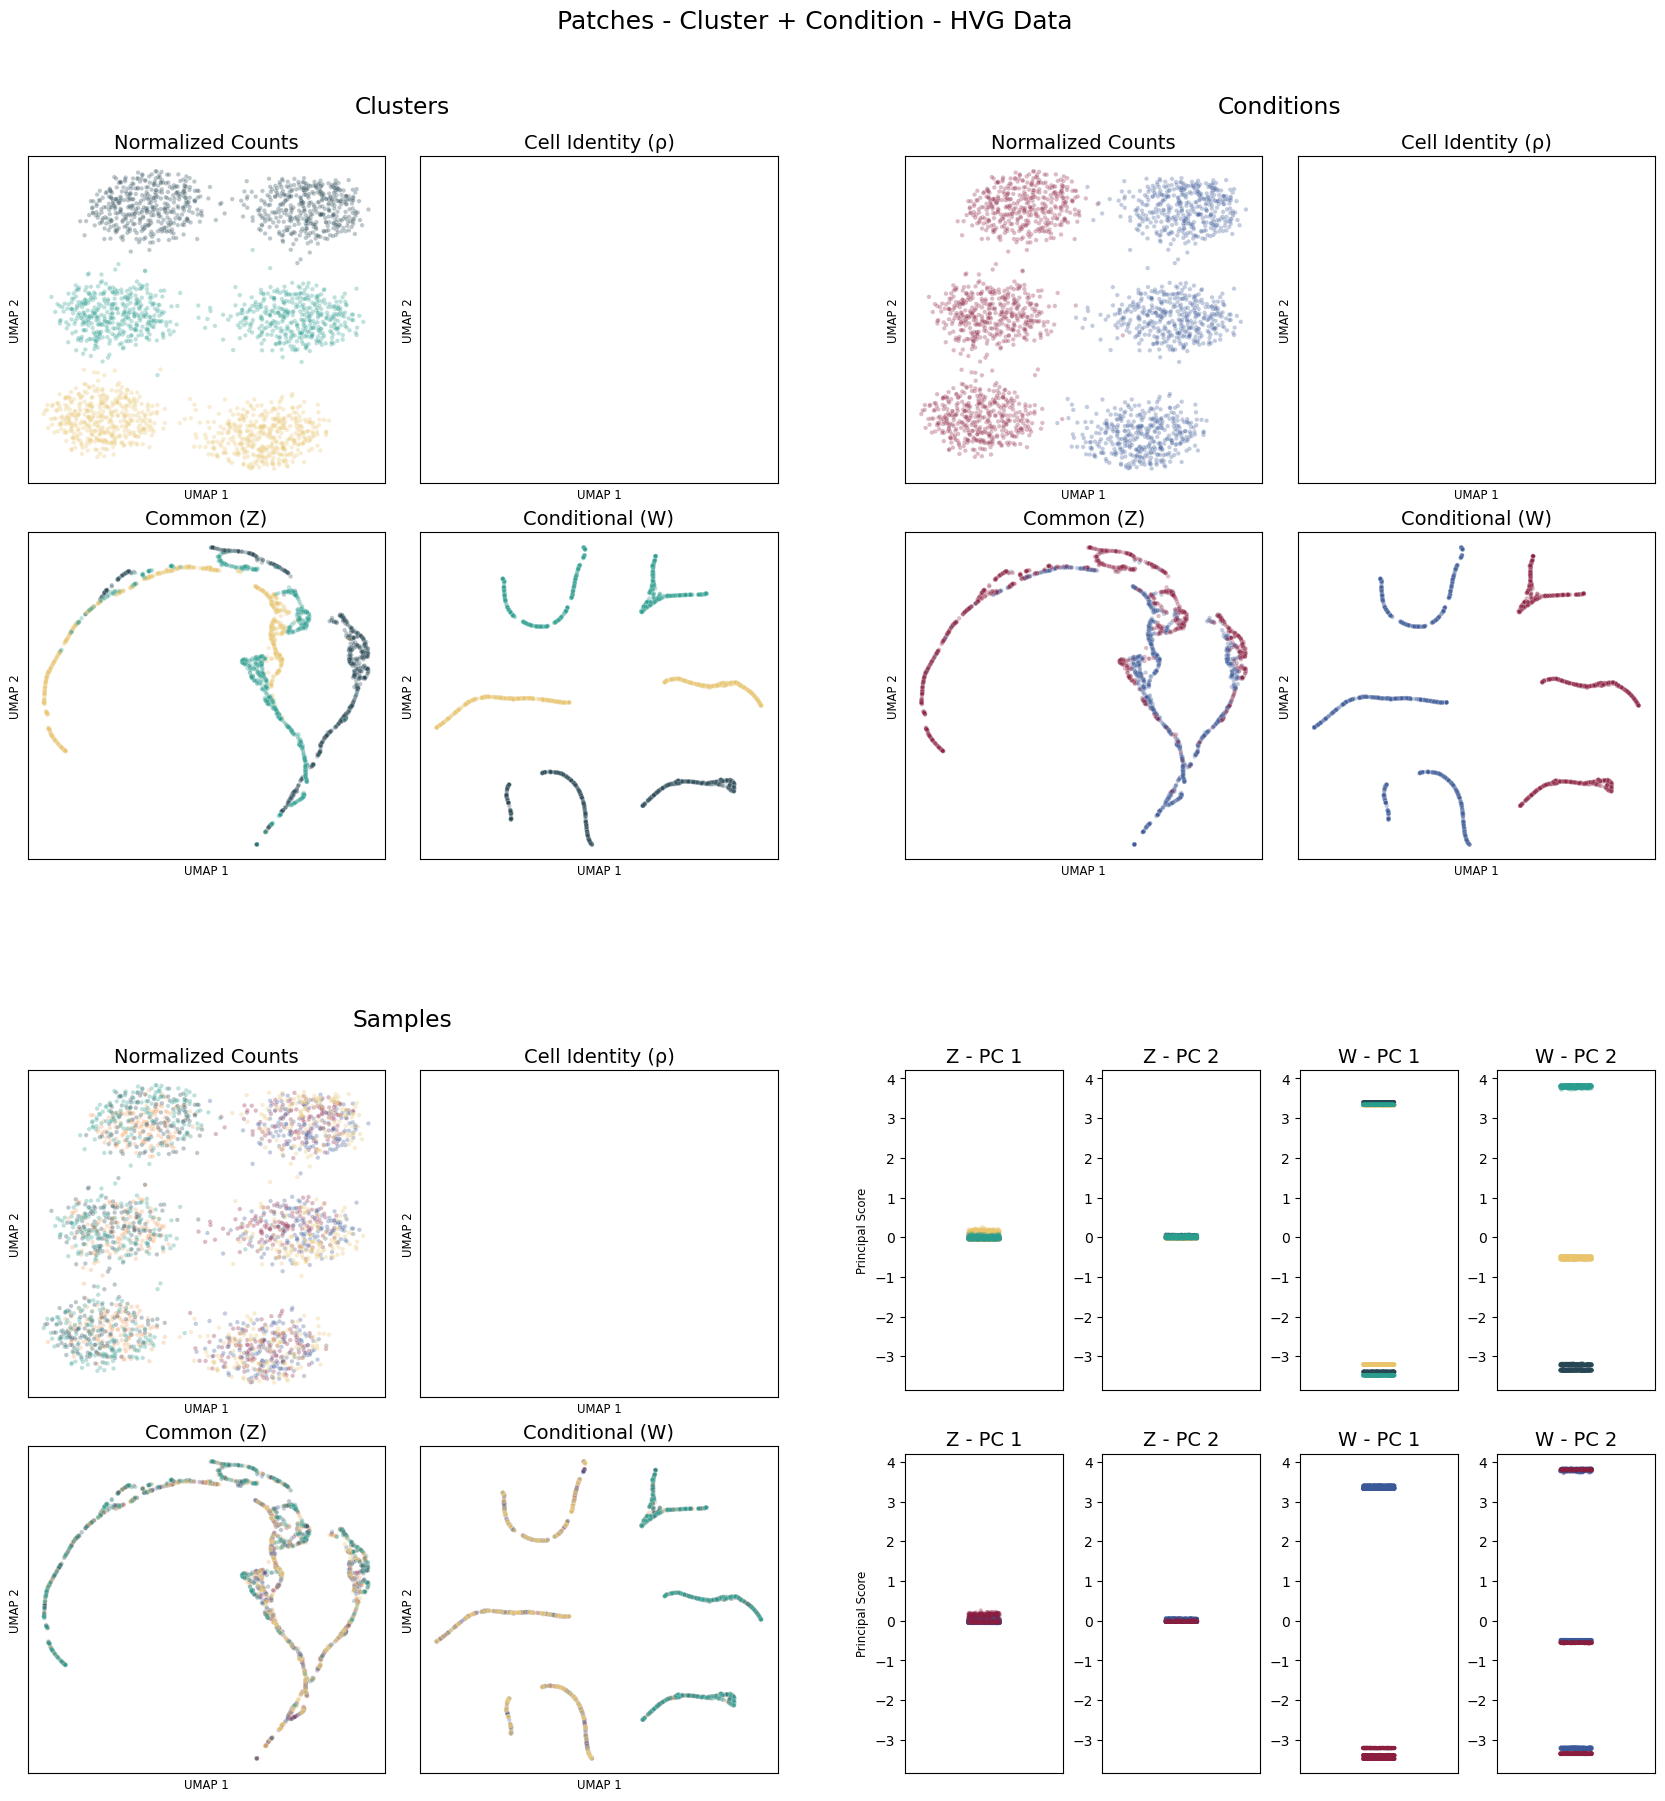

In [32]:
# Figure skeleton (adapted from Patches tutorial docs)


## create dataframes for plotting
df_patches = create_umap_df(workflow4, "Patches")
df_base = create_umap_df(workflow4, "Base")


## color palettes
klee_palette = [
    "#8B1E3F",  # Deep Burgundy
    "#3B5998",  # Rich Blue
    "#F4A261",  # Warm Orange
    "#264653",  # Deep Teal
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#D3D9E3",  # Soft Pastel Blue
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]

klee_palette_masch = [
    "#3B5998",  # Rich Blue
    "#6A994E",  # Fresh Olive Green
    "#F4A261",  # Warm Orange
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#FFC8A2",  # Soft Peach
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]


## plot parameters
fontsize=14
alpha=0.3
s=10
s_pca=3


## create a figure with a 2x2 grid of subplots
fig = plt.figure(figsize=(21, 21))

## define a GridSpec with a 2x2 layout
gs = gridspec.GridSpec(2, 2, wspace=0.17, hspace = 0.3, figure=fig)

## create subplots for the 2x2 grid
ax = [fig.add_subplot(gs[i//2, i%2]) for i in range(4)]

for subax in ax:
    subax.axis('off')

## define a new GridSpec for axis to split vertically
gs_inner_topleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 0], wspace=0.1, hspace=0.15)
gs_inner_topright = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 1], wspace=0.1, hspace=0.15)
gs_inner_botleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1, 0], wspace=0.1, hspace=0.15)
gs_inner_botright = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1, 1], wspace=0.25)

## create subplots for the inner grid
ax_inner_topleft = [fig.add_subplot(gs_inner_topleft[i//2, i%2]) for i in range(4)]
ax_inner_topright = [fig.add_subplot(gs_inner_topright[i//2, i%2]) for i in range(4)]
ax_inner_botleft = [fig.add_subplot(gs_inner_botleft[i//2, i%2]) for i in range(4)]

## specific for botright
ax_inner_botright = [fig.add_subplot(gs_inner_botright[0,0])]
ax_inner_botright = ax_inner_botright \
+ [
    fig.add_subplot(gs_inner_botright[0,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,3],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,0],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,3],sharey=ax_inner_botright[0]),
]


## UMAP plots

### counts
clu = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topright[0], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha)
con = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topleft[0], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha)
sam = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_botleft[0], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha)

### Zs
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topright[2], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topleft[2], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_botleft[2], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)

### Ws
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topright[3], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topleft[3], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_botleft[3], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)


## PCA plots

### cluster
sns.stripplot(df_patches, y = "z_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[0], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[0].axvline(zorder=2, color='black', linestyle = 'dashed')
    
sns.stripplot(df_patches, y = "z_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[1], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[1].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[2], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[2].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[3], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[3].axvline(zorder=2, color='black', linestyle = 'dashed')


### condition
sns.stripplot(df_patches, y = "z_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[4], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[4].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "z_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[5], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[5].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[6], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[6].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[7], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[7].axvline(zorder=2, color='black', linestyle = 'dashed')


## formatting

for subax in ax_inner_topright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_topleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_xlabel('')
    subax.set_ylabel('')

ax_inner_botright[0].set_ylabel('Principal Score', fontsize=fontsize*0.6)
ax_inner_botright[4].set_ylabel('Principal Score', fontsize=fontsize*0.6)

clu_h, clu_l = clu.get_legend_handles_labels() 
con_h, con_l = con.get_legend_handles_labels()
sam_h, sam_l = sam.get_legend_handles_labels()

clu.legend([], frameon=False); con.legend([], frameon=False); sam.legend([], frameon=False)

ax_inner_topleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_topright[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topright[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topright[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topright[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_botleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_botleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_botleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botright[0].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[1].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[2].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[3].set_title('W - PC 2', fontsize=fontsize)
ax_inner_botright[4].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[5].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[6].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[7].set_title('W - PC 2', fontsize=fontsize)


## set subplot titles
titles = ['Clusters', 'Conditions', 'Samples', '']

for a, t in zip(ax, titles):
    a.set_title(t, y=1.05, fontsize=fontsize*1.2)

    
## save and show figure
fig.suptitle("Patches - Cluster + Condition - HVG Data", fontsize=18, y=0.95)
plt.savefig("../../outs/sim/t100,s80,b0-patches_clu_con_hvg.png", dpi=300, bbox_inches='tight')
plt.show()

## Old Code

In [33]:
# sc.pp.neighbors(workflow.anndata, use_rep="PCA")
# sc.tl.umap(workflow.anndata)
# sc.pl.umap(workflow.anndata, color=["group_id", "cluster_id"], title=["PCA", "PCA"])

In [34]:
# sc.pp.neighbors(workflow.anndata, use_rep="patches_w_latent")
# sc.tl.umap(workflow.anndata)
# sc.pl.umap(workflow.anndata, color=["group_id", "cluster_id"], title=["Conditional (W)", "Conditional (W)"])

In [35]:
# sc.pp.neighbors(workflow.anndata, use_rep="patches_z_latent")
# sc.tl.umap(workflow.anndata)
# sc.pl.umap(workflow.anndata, color=["group_id", "cluster_id"], title=["Common (Z)", "Common (Z)"])